# Ops Tutorial
https://symforce.org/tutorials/ops_tutorial.html

SymForce uses concepts as an underlying mechanism. A concept is a specification of supported operations, including syntax and semantics, but does not require a subtype relationship. This means that a set of heterogenous types can be operated on in a homogenous way, i.e. types that are external and don’t share a base class, like Python floats treated as scalars.

There are three core concepts, each of which is a superset of the previous. The core routines use these ops interfaces rather than calling methods on types directly. The ops package docs provide much more detail and each op is tested on each type, but examples are given here.

In the case of lists of objects or a Values object (see the Values tutorial), we perform element-wise operations.

In [1]:
# Setup
import symforce

symforce.set_symbolic_api("sympy")
symforce.set_log_level("warning")

from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.values import Values
from symforce.ops import StorageOps, GroupOps, LieGroupOps

# StorageOps
StorageOps: Data type that can be serialized to and from a vector of scalar quantities.

Methods: .storage_dim(), .to_storage(), .from_storage(), .symbolic(), .evalf(), .subs(), .simplify()

Storage operations are used extensively for marshalling and for operating on each scalar in a type.

In [2]:
# Number of scalars used to represent a Pose3 (4 quaternion + 3 position)
display(StorageOps.storage_dim(sf.Pose3))

In [3]:
# Because we are using concepts, we can operate on types that aren't subtypes
# of symforce
display(StorageOps.storage_dim(float))

In [4]:
# Element-wise operations on lists of objects
display(StorageOps.storage_dim([sf.Pose3, sf.Pose3]))

In [5]:
# Element-wise operations on Values object with multiple types of elements
values = Values(
    pose=sf.Pose3(),
    scalar=sf.Symbol("x"),
)
display(StorageOps.storage_dim(values))  # 4 quaternion + 3 position + 1 scalar

In [6]:
# Serialize scalar
display(StorageOps.to_storage(5))

In [7]:
# Serialize vector/matrix
display(StorageOps.to_storage(sf.V3(sf.Symbol("x"), 5.2, sf.sqrt(5))))

In [8]:
# Serialize geometric type and reconstruct
T = sf.Pose3.symbolic("T")
T_serialized = StorageOps.to_storage(T)
T_recovered = StorageOps.from_storage(sf.Pose3, T_serialized)
display(T_serialized)
display(T_recovered)

<Pose3 R=<Rot3 <Q xyzw=[T.R_x, T.R_y, T.R_z, T.R_w]>>, t=(T.t0, T.t1, T.t2)>

# GroupOps
GroupOps: Mathematical group that implements closure, associativity, identity and invertibility.

Methods: .identity(), .inverse(), .compose(), .between()

Group operations provide the core methods to compare and combine types.

In [9]:
# Identity of a pose
display(GroupOps.identity(sf.Pose3))

<Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(0, 0, 0)>

In [10]:
# Identity of a scalar (under addition)
display(GroupOps.identity(float))

In [11]:
# Inverse of a vector
display(GroupOps.inverse(sf.V3(1.2, -3, 2)).T)

[-1.2  3  -2]

In [12]:
# Compose two vectors (under addition)
display(GroupOps.compose(sf.V2(1, 2), sf.V2(3, -5)))

⎡4 ⎤
⎢  ⎥
⎣-3⎦

In [13]:
# Compose a rotation and its inverse to get identity
R1 = sf.Rot3.from_angle_axis(
    angle=sf.Symbol("theta1"),
    axis=sf.V3(0, 0, 1),
)
display(StorageOps.simplify(GroupOps.compose(R1, R1.inverse()).simplify()))

<Rot3 <Q xyzw=[0, 0, 0, 1]>>

In [14]:
# Relative rotation using `.between()`
R2 = sf.Rot3.from_angle_axis(
    angle=sf.Symbol("theta2"),
    axis=sf.V3(0, 0, 1),
)
R_delta = GroupOps.between(R1, R2)
display(R2)
display(StorageOps.simplify(GroupOps.compose(R1, R_delta)))

<Rot3 <Q xyzw=[0, 0, sin(theta2/2), cos(theta2/2)]>>

<Rot3 <Q xyzw=[0, 0, sin(theta2/2), cos(theta2/2)]>>

# LieGroupOps
LieGroupOps: Group that is also a differentiable manifold, such that calculus applies.

Methods: .tangent_dim(), .from_tangent(), to_tangent(), .retract(), .local_coordinates(), .storage_D_tangent()

Lie group operations provide the core methods for nonlinear optimization.
Familiarity is not expected for all users, but learning is encouraged!

In [15]:
# Underlying dimension of a 3D rotation's tangent space
display(LieGroupOps.tangent_dim(sf.Rot3))

In [16]:
# Exponential map (tangent space vector wrt identity element) for a 2D rotation
angle = sf.Symbol("theta")
rot2 = LieGroupOps.from_tangent(sf.Rot2, [angle])
display(rot2.to_rotation_matrix())

⎡cos(θ)  -sin(θ)⎤
⎢               ⎥
⎣sin(θ)  cos(θ) ⎦

In [17]:
# Logarithmic map (tangent space wrt identity element -> element) of the rotation
display(LieGroupOps.to_tangent(rot2))

In [18]:
# Exponential map of a vector type is a no-op
display(LieGroupOps.from_tangent(sf.V5(), [1, 2, 3, 4, 5]).T)

[1  2  3  4  5]

In [20]:
# Retract perturbs the given element in the tangent space and returns the
# updated element
rot2_perturbed = LieGroupOps.retract(rot2, [sf.Symbol("delta")]) # compose(a, from_tangent(vec)).
display(rot2_perturbed.to_rotation_matrix())
display(rot2_perturbed.to_tangent())

⎡-sin(δ)⋅sin(θ) + cos(δ)⋅cos(θ)  -sin(δ)⋅cos(θ) - sin(θ)⋅cos(δ)⎤
⎢                                                              ⎥
⎣sin(δ)⋅cos(θ) + sin(θ)⋅cos(δ)   -sin(δ)⋅sin(θ) + cos(δ)⋅cos(θ)⎦

In [21]:
# Local coordinates compute the tangent space perturbation between one element
# and another
display(StorageOps.simplify(LieGroupOps.local_coordinates(rot2, rot2_perturbed)))

In [22]:
# storage_D_tangent computes the jacobian of the storage space of an object with
# respect to the tangent space around the element.

# A 2D rotation is represented by a complex number, so storage_D_tangent
# represents how that complex number will change given an infinitesimal
# perturbation in the tangent space
display(LieGroupOps.storage_D_tangent(rot2))

⎡-sin(θ)⎤
⎢       ⎥
⎣cos(θ) ⎦

Using symbolic geometric types and concepts is already very powerful for development and analysis of robotics, but operating on symbolic objects at runtime is much too slow for most applications. However, symbolic expressions can be beautifully set to fast runtime code.

⎡ Ri_w   -Ri_z    Ri_y ⎤
⎢ ────   ──────   ──── ⎥
⎢  2       2       2   ⎥
⎢                      ⎥
⎢ Ri_z    Ri_w   -Riₓ  ⎥
⎢ ────    ────   ───── ⎥
⎢  2       2       2   ⎥
⎢                      ⎥
⎢-Ri_y    Riₓ     Ri_w ⎥
⎢──────   ───     ──── ⎥
⎢  2       2       2   ⎥
⎢                      ⎥
⎢-Riₓ    -Ri_y   -Ri_z ⎥
⎢─────   ──────  ──────⎥
⎣  2       2       2   ⎦

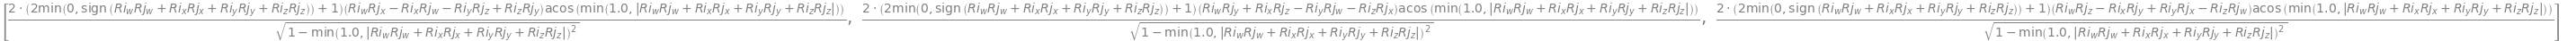

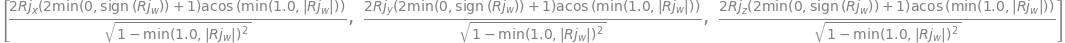

⎡   ⎛        2         2    ⎞                                                 
⎢L₀⋅⎝- 2⋅Ri_y  - 2⋅Ri_z  + 1⎠ + L₁⋅(2⋅Ri_w⋅Ri_z + 2⋅Riₓ⋅Ri_y) + L₂⋅(-2⋅Ri_w⋅Ri
⎢                                                                             
⎢                                    ⎛       2         2    ⎞                 
⎢L₀⋅(-2⋅Ri_w⋅Ri_z + 2⋅Riₓ⋅Ri_y) + L₁⋅⎝- 2⋅Riₓ  - 2⋅Ri_z  + 1⎠ + L₂⋅(2⋅Ri_w⋅Riₓ
⎢                                                                             
⎢                                                                    ⎛       2
⎣L₀⋅(2⋅Ri_w⋅Ri_y + 2⋅Riₓ⋅Ri_z) + L₁⋅(-2⋅Ri_w⋅Riₓ + 2⋅Ri_y⋅Ri_z) + L₂⋅⎝- 2⋅Riₓ 

                ⎤
_y + 2⋅Riₓ⋅Ri_z)⎥
                ⎥
                ⎥
 + 2⋅Ri_y⋅Ri_z) ⎥
                ⎥
         2    ⎞ ⎥
 - 2⋅Ri_y  + 1⎠ ⎦

⎡                                                                             
⎢                                                 0                           
⎢                                                                             
⎢                                                                     ⎛    2  
⎢ L₀⋅(2⋅Ri_w⋅Ri_y + 2⋅Riₓ⋅Ri_z) + L₁⋅(-2⋅Ri_w⋅Riₓ + 2⋅Ri_y⋅Ri_z) + L₂⋅⎝Ri_w  -
⎢                                                                             
⎢                                   ⎛      2      2       2       2⎞          
⎣L₀⋅(2⋅Ri_w⋅Ri_z - 2⋅Riₓ⋅Ri_y) + L₁⋅⎝- Ri_w  + Riₓ  - Ri_y  + Ri_z ⎠ + L₂⋅(-2⋅

                                                                              
                         L₀⋅(-2⋅Ri_w⋅Ri_y - 2⋅Riₓ⋅Ri_z) + L₁⋅(2⋅Ri_w⋅Riₓ - 2⋅R
                                                                              
    2       2       2⎞                                                        
 Riₓ  - Ri_y  + Ri_z ⎠                             

In [42]:
Ri = sf.Rot3.symbolic("Ri")
Rj = sf.Rot3.symbolic("Rj")
deltaR = LieGroupOps.local_coordinates(Ri, Rj)
display(LieGroupOps.storage_D_tangent(Ri))

display(deltaR)

drj = LieGroupOps.to_tangent(Rj)
display(drj)
Rij = LieGroupOps.retract(Ri, drj)

landmark = sf.V3.symbolic("L")
landmark_cam = Ri.inverse() * landmark
display(landmark_cam)
display(landmark_cam.jacobian(Ri))